## Individual cell-based differential transcriptomic analysis across conditions

In [1]:
path = '/home/mid166/Analysis/Jupyter/Python/Package/PIASO_github'
import sys
sys.path.append(path)
import piaso ## Available in https://github.com/genecell/PIASO

In [2]:
import scanpy as sc

In [3]:
import pandas as pd
import numpy as np

In [4]:
sc.set_figure_params(dpi=80,dpi_save=300, color_map='viridis',facecolor='white')
from matplotlib import rcParams
rcParams['figure.figsize'] = 4, 4
save_dir='/n/data1/hms/neurobio/fishell/mindai/Result/single-cell/Methods/Emergene'
sc.settings.figdir = save_dir
prefix='Emergene_Tutorial'

### Load the data

The 25k subsampled snRNA-seq data `SEA-AD_CaseControl_subset_log1p_25k.h5ad` from Allen SEA-AD project is available in google drive: https://drive.google.com/file/d/1YLdzJPFuKFrSYTc82bLMKmFGSZwsTAck.

The original data is available in https://portal.brain-map.org/explore/seattle-alzheimers-disease.

You can use gdrive to download the above dataset to your space:
```
mkdir -p /n/data1/hms/neurobio/fishell/mindai/Result/single-cell/Methods/Emergene/
cd /n/data1/hms/neurobio/fishell/mindai/Result/single-cell/Methods/Emergene/
gdrive files download 1YLdzJPFuKFrSYTc82bLMKmFGSZwsTAck
```

In [5]:
adata=sc.read('/n/data1/hms/neurobio/fishell/mindai/Result/single-cell/Methods/Emergene/SEA-AD_CaseControl_subset_log1p_25k.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 25600 × 36601
    obs: 'sample_id', 'Neurotypical reference', 'Donor ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA in mont

In [7]:
pd.crosstab(adata.obs['Neurotypical reference'], adata.obs['CERAD score'])

CERAD score             Absent  Frequent
Neurotypical reference                  
False                    10264     15336

### Check the cell type composition

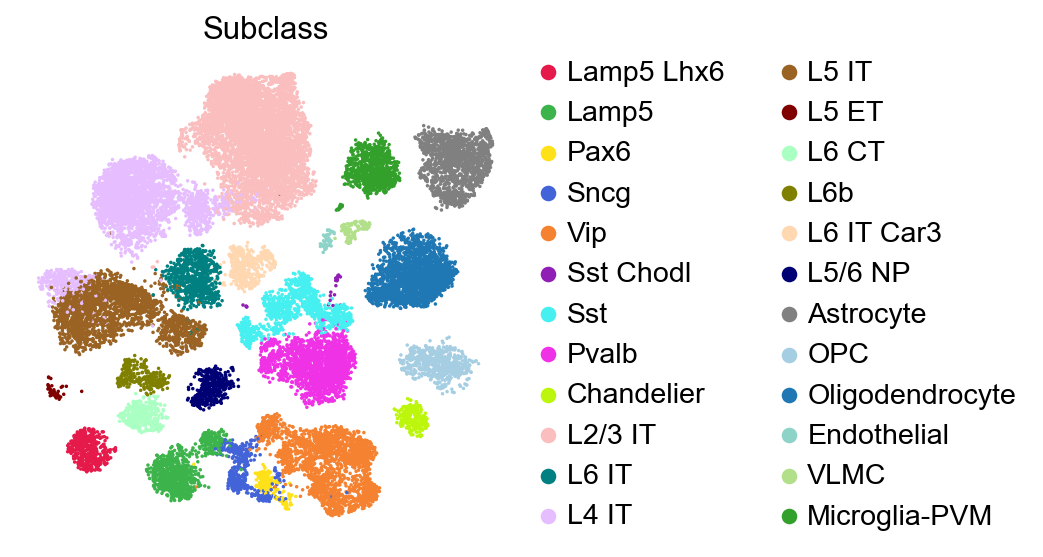

In [8]:
sc.pl.embedding(adata,
            basis='X_umap',
           color=['Subclass'],
           palette=piaso.pl.color.d_color3,
           legend_fontoutline=2,
           legend_fontweight=5,
           cmap='Spectral_r',
           ncols=3,
           size=10,
           frameon=False)

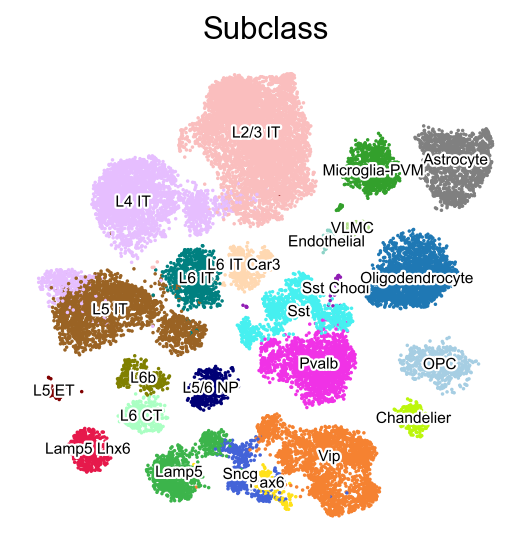

In [9]:
sc.pl.embedding(adata,
    basis='X_umap',
    color=['Subclass'],
    palette=piaso.pl.color.d_color3,
    legend_fontoutline=2,
    legend_fontsize=7,
    legend_fontweight=5,
    legend_loc='on data',
    cmap='Spectral_r',
    ncols=3,
    size=10,
    frameon=False)

### Run Emergene

In [75]:
path = '/home/mid166/Analysis/Jupyter/Python/Package/Emergene_github/emergene'
import sys
sys.path.append(path)
import emergene ## Available in https://github.com/genecell/Emergene

In [76]:
import importlib
importlib.reload(emergene)

<module 'emergene' from '/home/mid166/Analysis/Jupyter/Python/Package/Emergene_github/emergene/emergene.py'>

In [91]:
%%time
emergene.infog(adata, layer='UMIs')

/home/mid166/Analysis/Jupyter/Python/Package/Emergene_github/emergene/emergene.py:1024: RuntimeWarning: divide by zero encountered in true_divide
  info_factor=sparse.diags(counts_sum/cell_depth.ravel()) @ counts @ sparse.diags(1/gene_depth.ravel())


The normalized data is saved as `infog` in `adata.layers`.
The highly variable genes are saved as `highly_variable_infog` in `adata.obs`.
Finished INFOG normalization.
CPU times: user 10.9 s, sys: 10.8 s, total: 21.6 s
Wall time: 21.6 s


In [92]:
%%time
EG_top_geneset_dict, EG_score_all=emergene.EmerGene(
    adata,
    layer='infog',
    use_rep='X_scVI',
    use_rep_acrossDataset='X_scVI',
    condition_key='Condition',
    n_nearest_neighbors=10,
    n_repeats=5,
    mu=0.1,
    beta=1,
    random_seed=27,
    n_cells_expressed_threshold = 50, ### Change the number of cells threshold
    n_top_EG_genes = 500, ### Change the number of top gene with highest Emergene scores
    inplace=False,
    gene_list_as_string=True,
)

Processing condition:  Control
The EmerGene scores for all genes in condition Control are saved in the dataframe column 'EmerGene_Control'.
Processing condition:  Disease
The EmerGene scores for all genes in condition Disease are saved in the dataframe column 'EmerGene_Disease'.
The local foldchange information for each individual cells is saved as `localFC` in adata.layers.
Finished running the EmerGene.
CPU times: user 4min 23s, sys: 2min 12s, total: 6min 35s
Wall time: 5min 51s


### Calculate enrichment score and p-values for each individual cell

Use 1000 permutations:

In [93]:
EG_top_geneset_dict.keys()

dict_keys(['EG_Control', 'EG_Disease'])

In [94]:
%%time
valid_genes = set(adata.var_names)
for group, gene_and_weight in EG_top_geneset_dict.items():
    # Parse and filter the dictionary in one step, only keep the genes in adata.var_names
    gene_dict = {k: float(v) for k, v in (item.split(":") for item in gene_and_weight.split(",")) if k in valid_genes}
    gene_list=list(gene_dict.keys())
    gene_weight=list(gene_dict.values())
    print(f'Processing {group}')
    
    
    emergene.score(
        adata,
        gene_list=gene_list,
        gene_weights=gene_weight,
        layer='localFC',
        # gene_weights=np.repeat(1.0, len(gene_list)),
        n_nearest_neighbors=30,
        randome_seed=27,
        n_ctrl_set=1000,
        key_added=f'INFOG_{group}',       
    )

Processing EG_Control
Processing EG_Disease
CPU times: user 54.3 s, sys: 40.2 s, total: 1min 34s
Wall time: 1min 34s


In [95]:
for key in EG_top_geneset_dict.keys():
    print(key)
    adata.obs[f'{key}_score']=adata.uns[f'INFOG_{key}']['score']
    adata.obs[f'{key}_nlog10_pval']=adata.uns[f'INFOG_{key}']['nlog10_pval']
    adata.obs[f'{key}_nlog10_FDR']=adata.uns[f'INFOG_{key}']['nlog10_pval_FDR']
    adata.obs[f'{key}_pval']=adata.uns[f'INFOG_{key}']['pval']
    adata.obs[f'{key}_FDR']=adata.uns[f'INFOG_{key}']['pval_FDR']
    adata.obs[f'{key}_pval_mc']=adata.uns[f'INFOG_{group}']['pval_mc']
    adata.obs[f'{key}_nlog10_pval_mc']=adata.uns[f'INFOG_{key}']['nlog10_pval_mc']
    adata.obs[f'{key}_nlog10_mc_FDR']=adata.uns[f'INFOG_{key}']['nlog10_pval_mc_FDR']

EG_Control
EG_Disease


In [96]:
adata.obs['SubclassXCondition'] = piaso.pp.getCrossCategories(adata.obs, 'Subclass', 'Condition', )

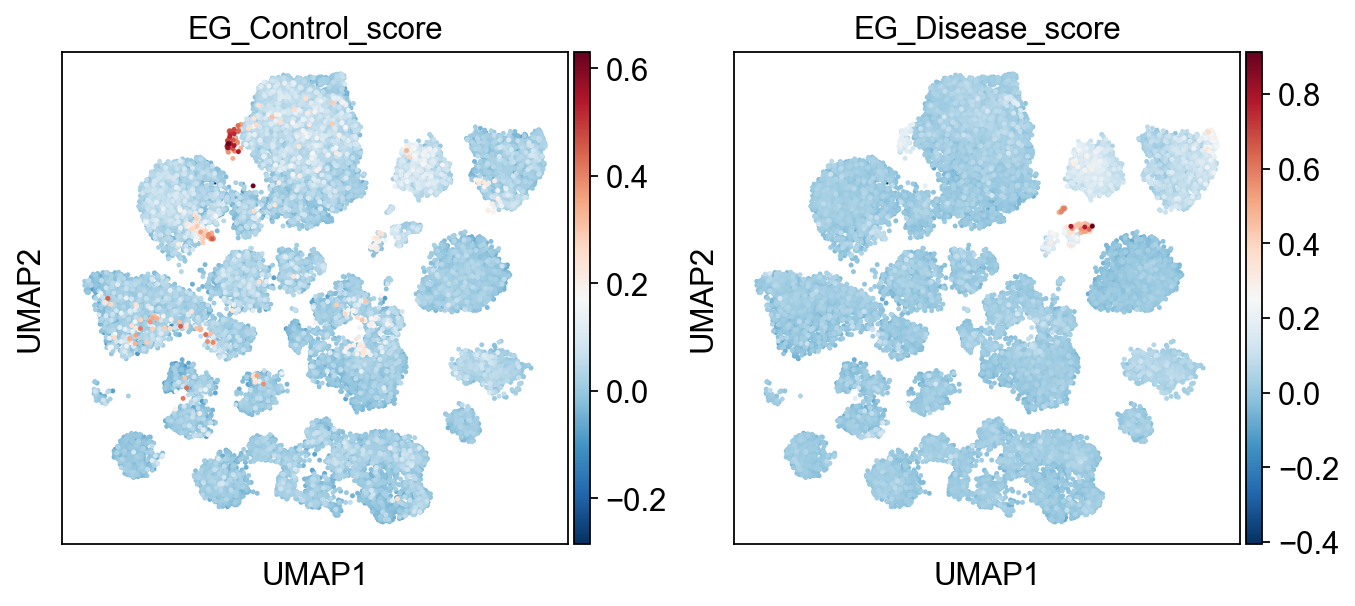

In [97]:
sc.pl.umap(
    adata,
    color=[key+'_score' for key in EG_top_geneset_dict.keys()],
    color_map="RdBu_r",
    # color_map=piaso.pl.color.c_color4,
    # vmin=-5,
    # vmax=5,
    s=20,
)

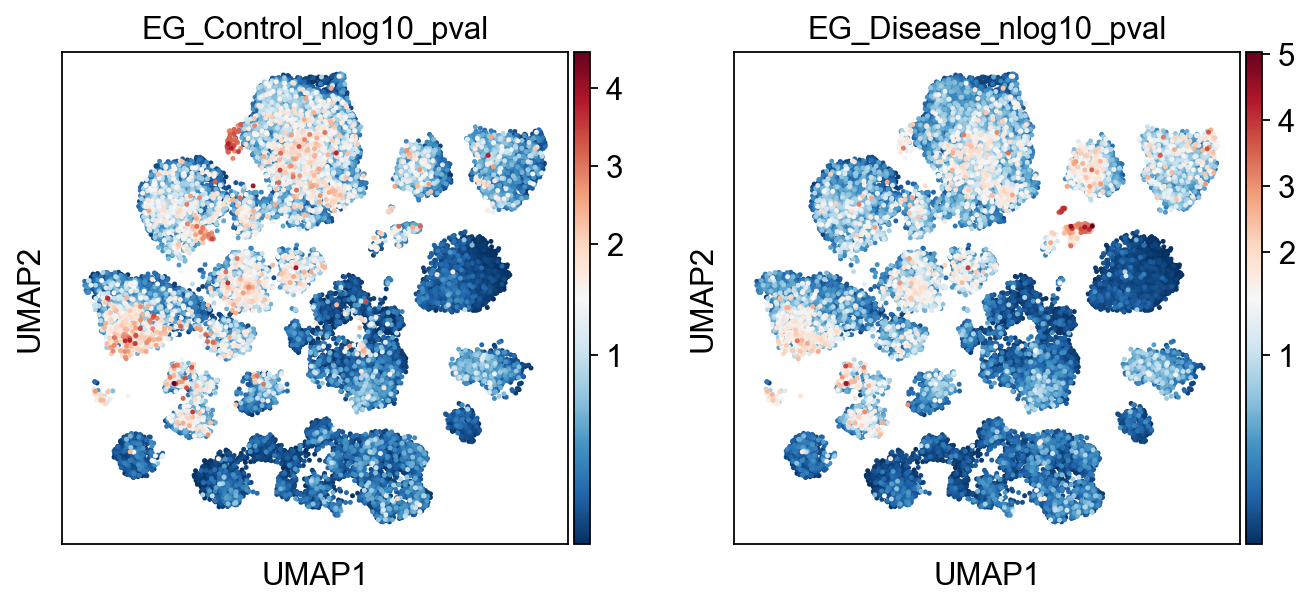

In [98]:
sc.pl.umap(
    adata,
    color=[key+'_nlog10_pval' for key in EG_top_geneset_dict.keys()],
    color_map="RdBu_r",
    # color_map=piaso.pl.color.c_color4,
    vcenter=-np.log10(0.05),
    # vmin=-5,
    # vmax=5,
    s=20,
)

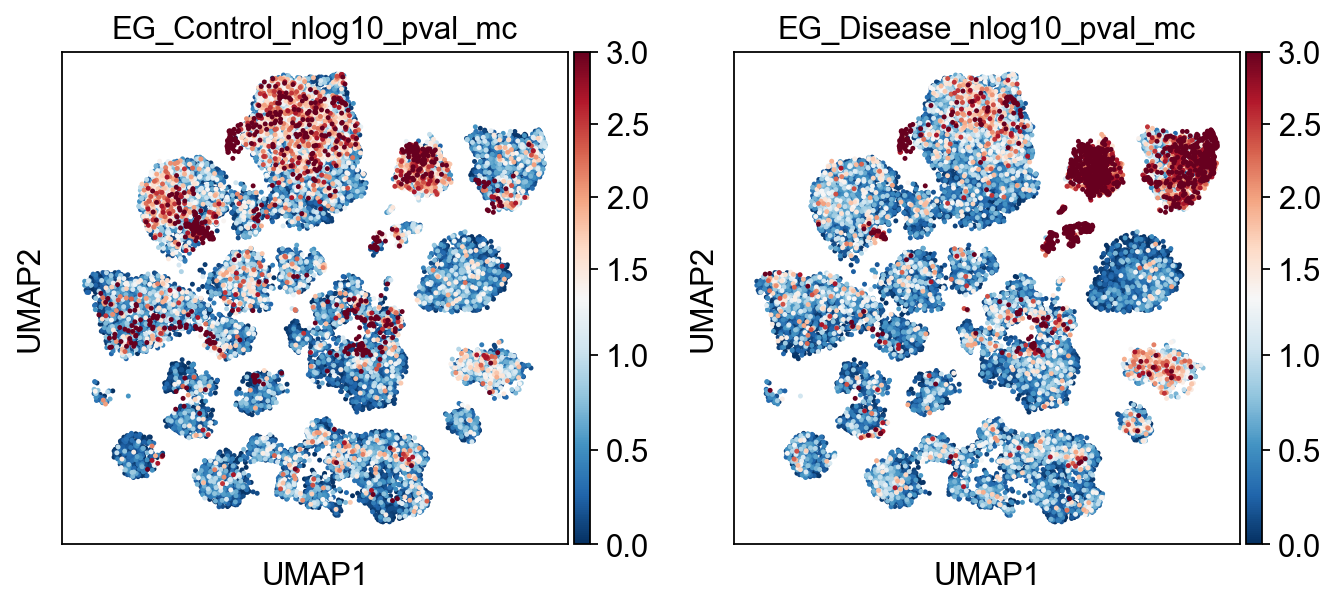

In [99]:
sc.pl.umap(
    adata,
    color=[key+'_nlog10_pval_mc' for key in EG_top_geneset_dict.keys()],
    color_map="RdBu_r",
    vcenter=-np.log10(0.05),
    s=20,
)

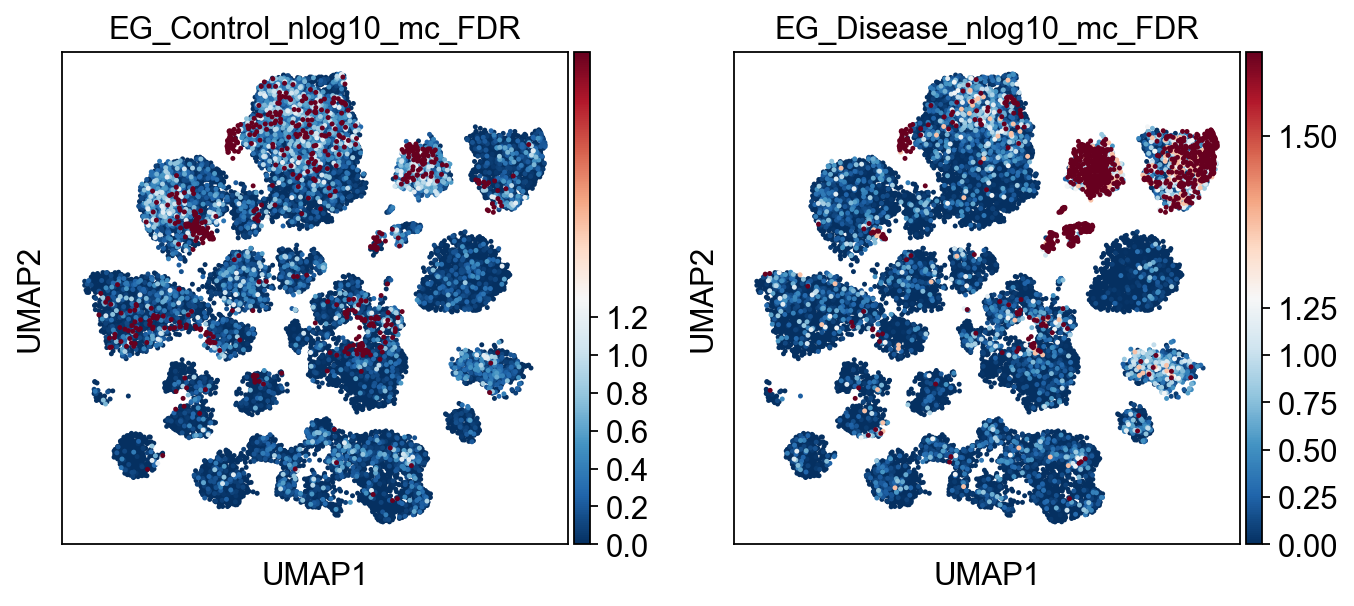

In [106]:
sc.pl.umap(
    adata,
    color=[key+'_nlog10_mc_FDR' for key in EG_top_geneset_dict.keys()],
    color_map="RdBu_r",
    vcenter=-np.log10(0.05),
    s=20,
)

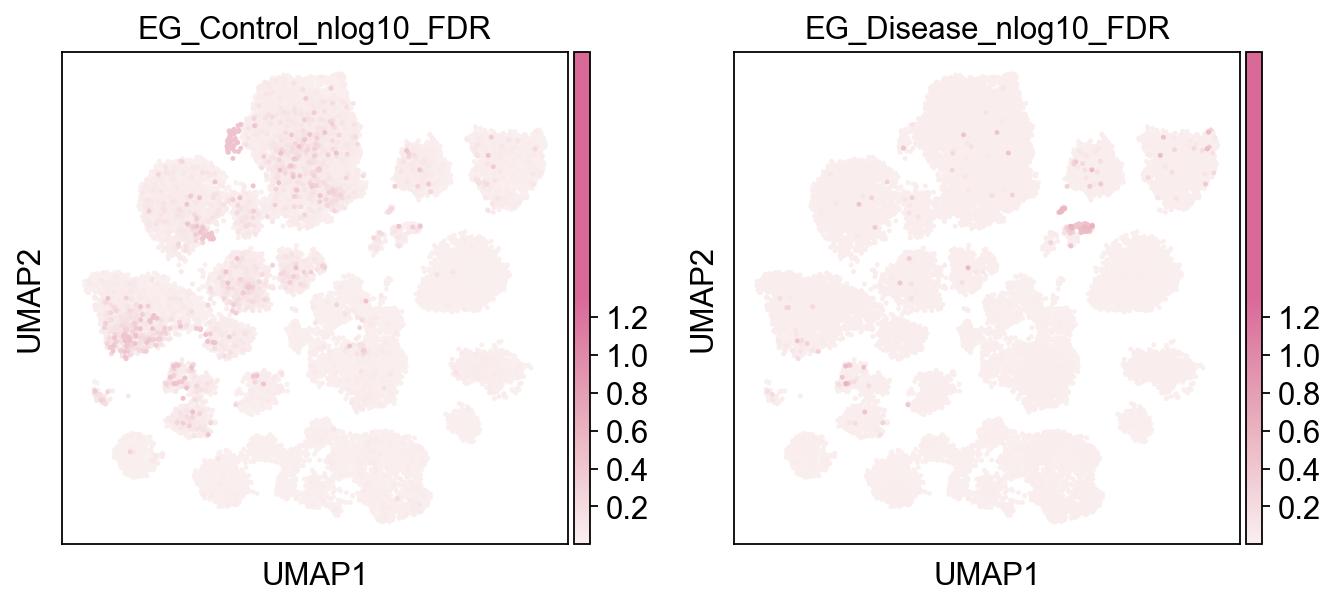

In [107]:
sc.pl.umap(
    adata,
    color=[key+'_nlog10_FDR' for key in EG_top_geneset_dict.keys()],
    # color_map="RdBu_r",
    color_map=piaso.pl.color.c_color4,
    vcenter=-np.log10(0.05),
    # vmin=-5,
    # vmax=5,
    s=20,
)

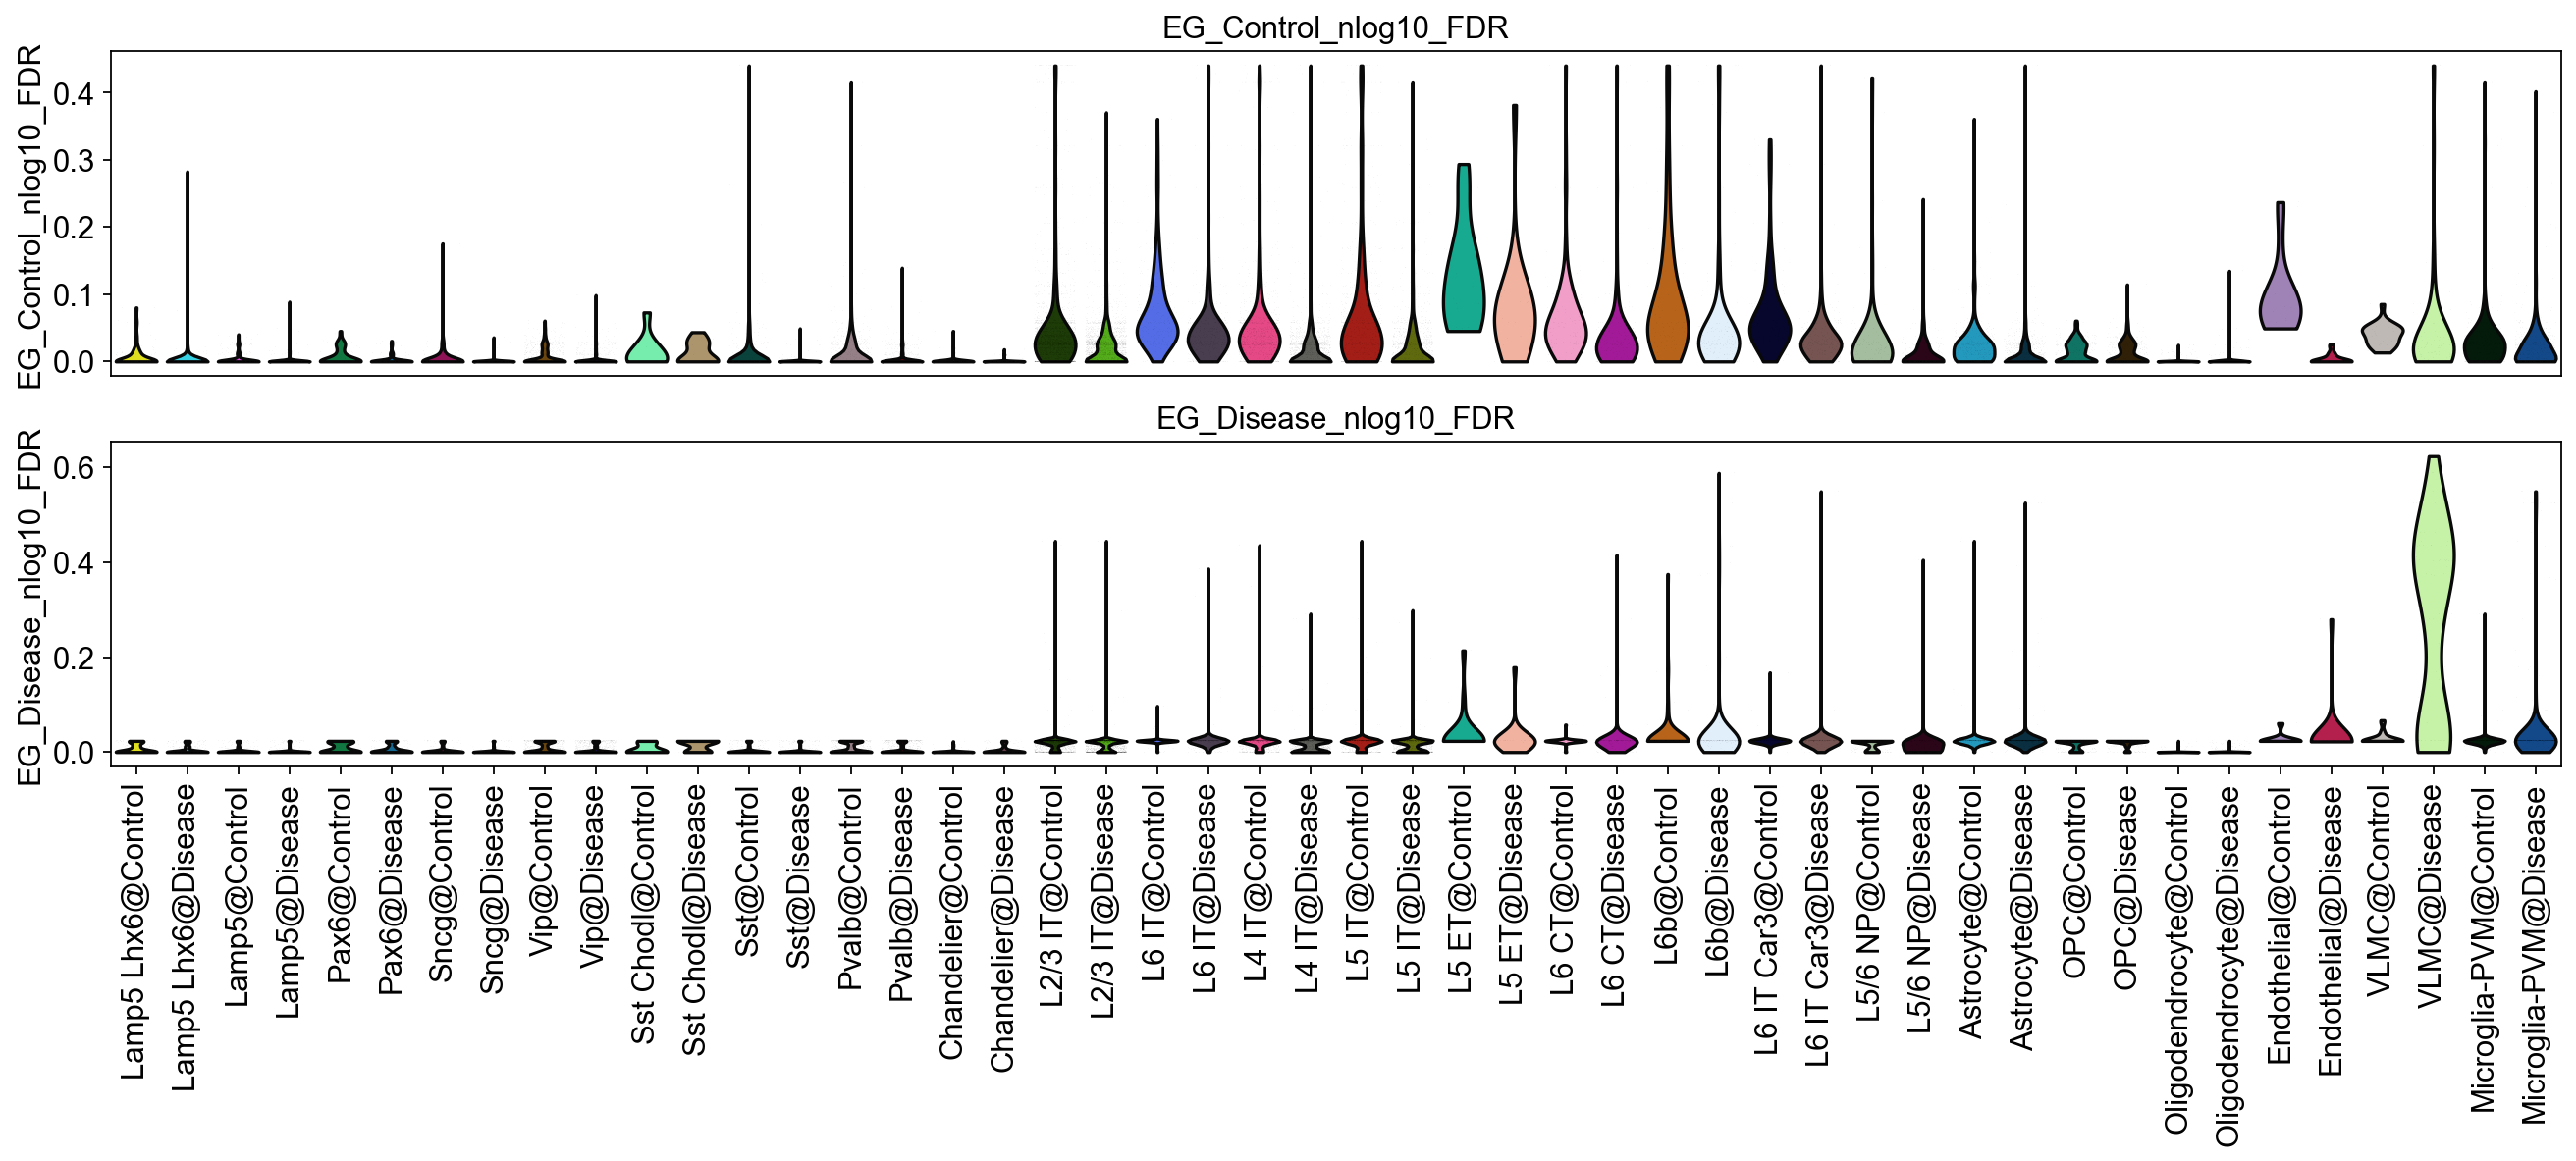

In [108]:
piaso.pl.plot_features_violin(adata,
    feature_list=[key+'_nlog10_FDR' for key in EG_top_geneset_dict.keys()],
    width_single=20,
    height_single=3,
    groupby='SubclassXCondition',
    show_grid=False
                             )

In [109]:
for key in EG_top_geneset_dict.keys():
    tmp=adata.obs[key+'_nlog10_pval_mc'].copy()
    tmp[tmp<= (-np.log10(0.05))]=0
    adata.obs[key+'_nlog10_mc_trim']=tmp

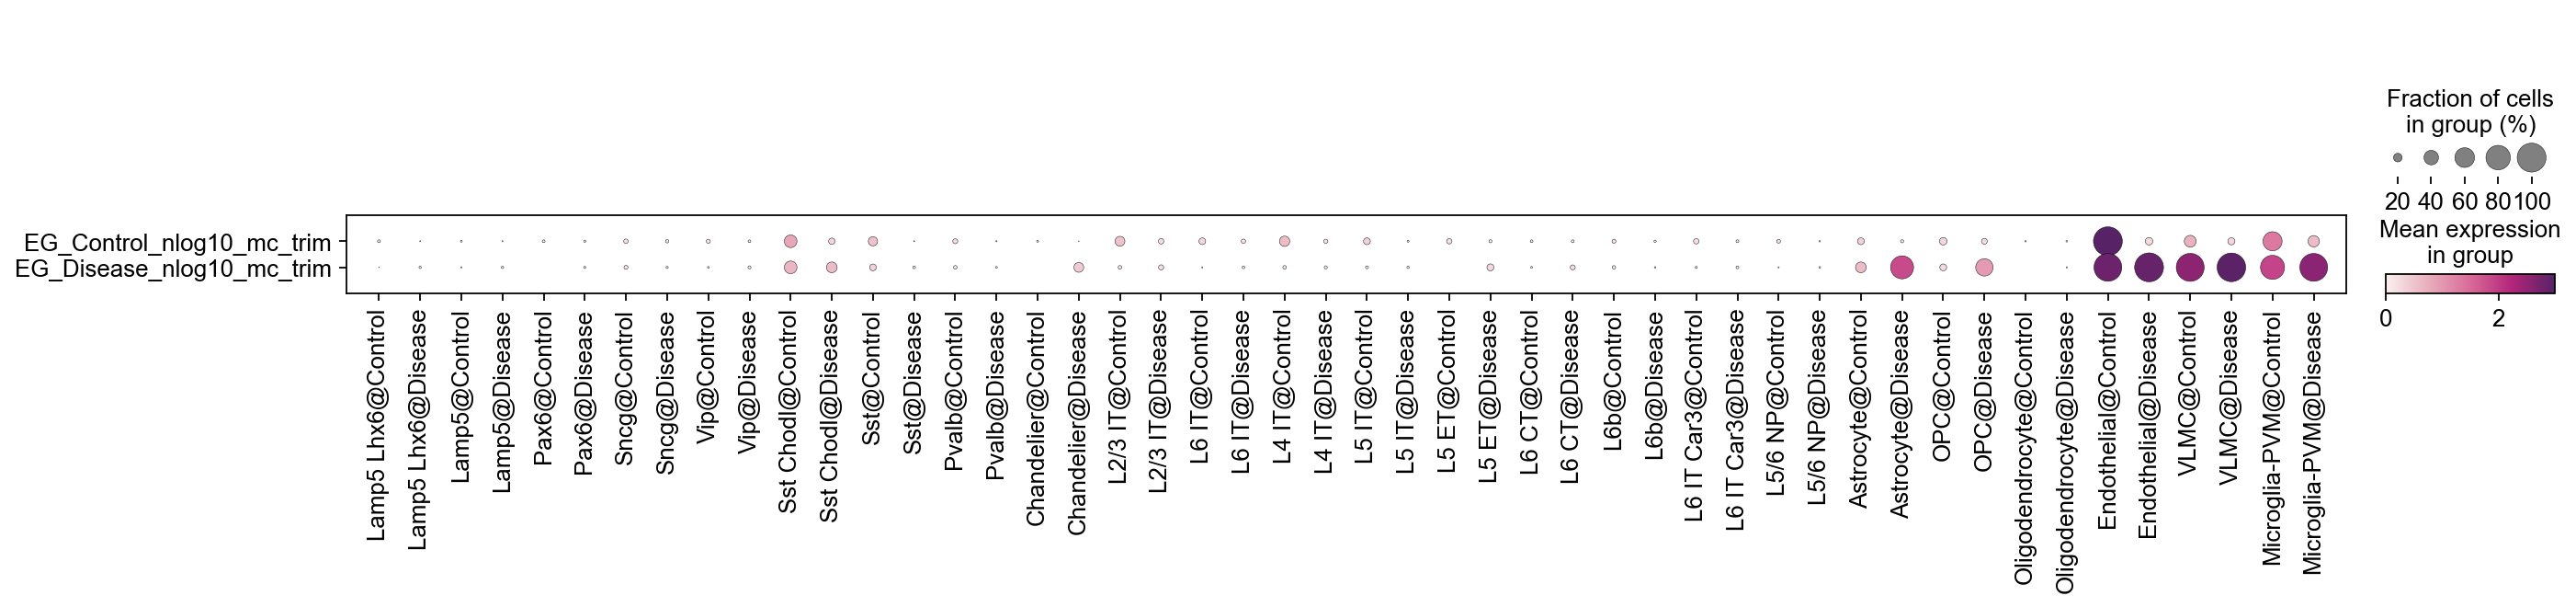

In [110]:
sc.pl.dotplot(
    adata,
    var_names=[key+'_nlog10_mc_trim' for key in EG_top_geneset_dict.keys()],
    groupby='SubclassXCondition',
    swap_axes=True,
    cmap=piaso.pl.color.c_color4
)

In [111]:
for key in EG_top_geneset_dict.keys():
    tmp=adata.obs[key+'_nlog10_mc_FDR'].copy()
    tmp[tmp<= (-np.log10(0.05))]=0
    # tmp[tmp<= (-np.log10(0.1))]=0
    adata.obs[key+'_nlog10_mc_FDR_trim']=tmp

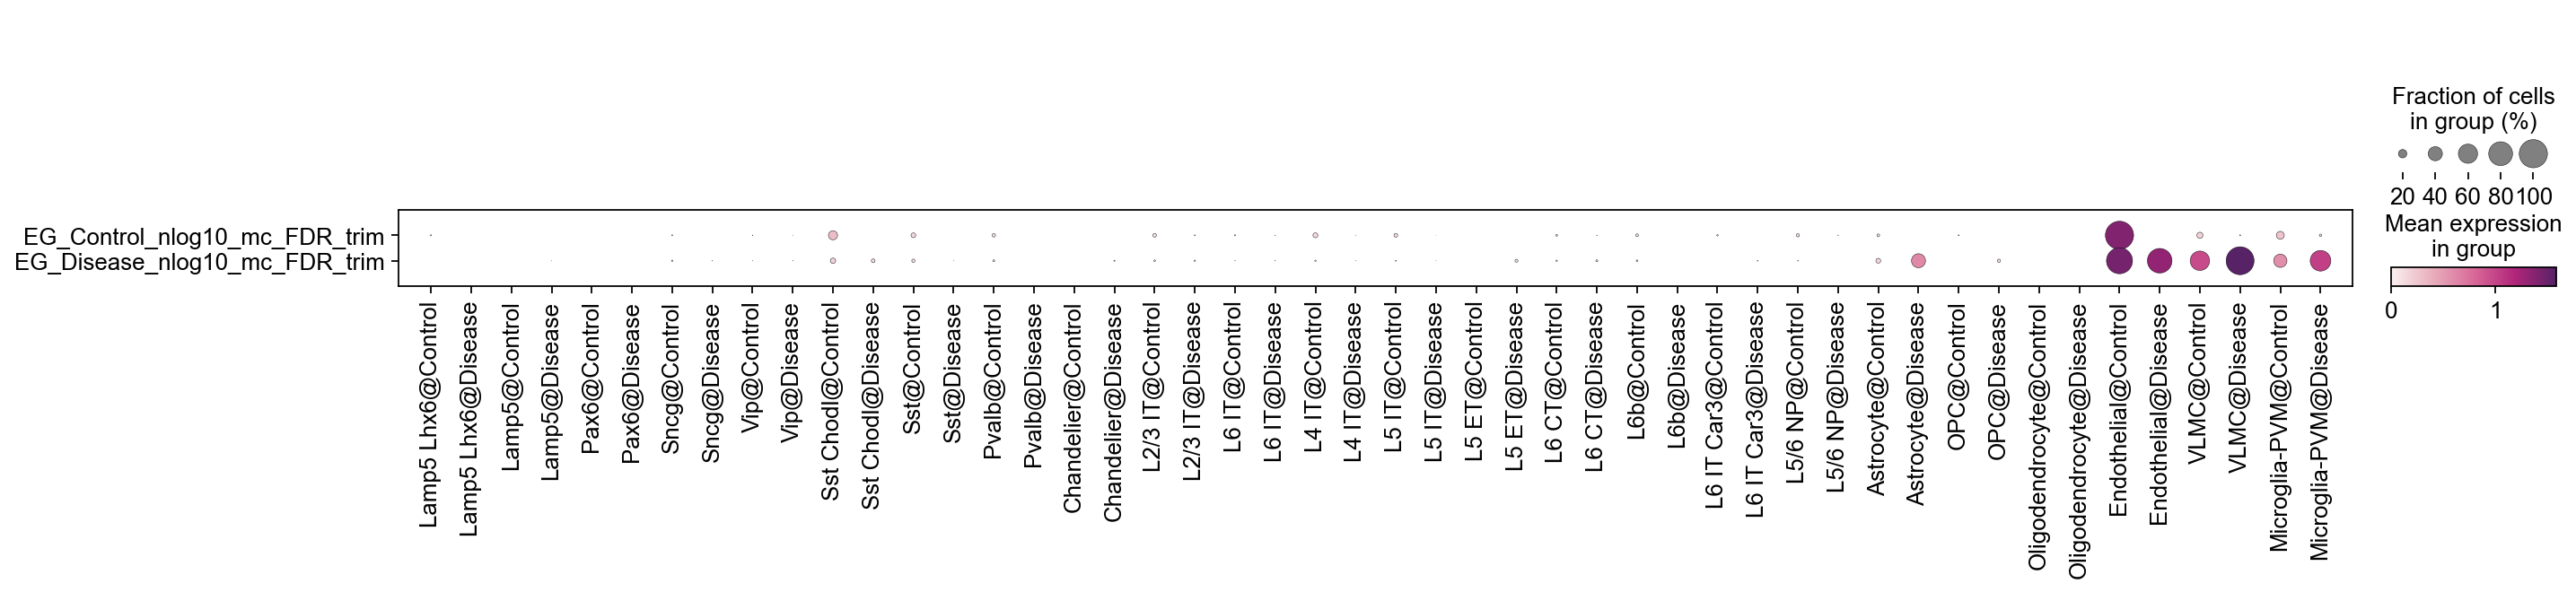

In [112]:
sc.pl.dotplot(
    adata,
    var_names=[key+'_nlog10_mc_FDR_trim' for key in EG_top_geneset_dict.keys()],
    groupby='SubclassXCondition',
    swap_axes=True,
    cmap=piaso.pl.color.c_color4
)

In [113]:
for key in EG_top_geneset_dict.keys():
    tmp=adata.obs[key+'_nlog10_FDR'].copy()
    # tmp[tmp<= (-np.log10(0.05))]=0
    tmp[tmp<= (-np.log10(0.1))]=0
    adata.obs[key+'_nlog10_FDR_trim']=tmp

/home/mid166/.conda/envs/scda4/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:697: RuntimeWarning: invalid value encountered in true_divide
  frac = (frac - dot_min) / old_range


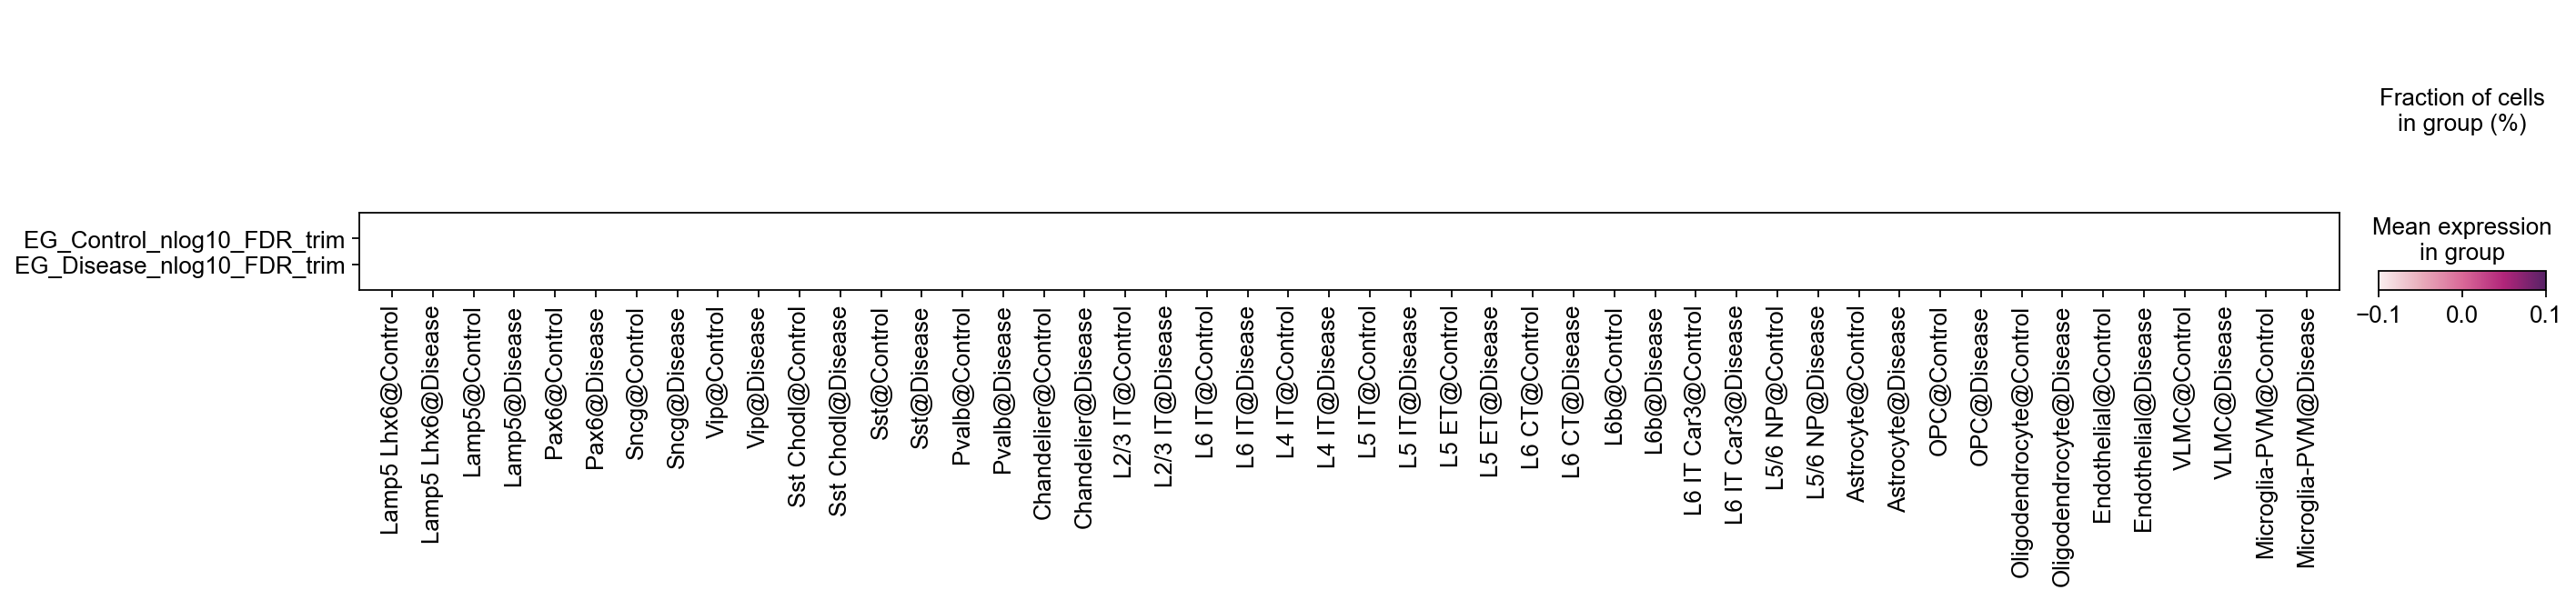

In [114]:
sc.pl.dotplot(
    adata,
    var_names=[key+'_nlog10_FDR_trim' for key in EG_top_geneset_dict.keys()],
    groupby='SubclassXCondition',
    swap_axes=True,
    cmap=piaso.pl.color.c_color4
)

In [61]:
EG_top_geneset_df=emergene.convertTopGeneDictToDF(
    EG_top_geneset_dict,
    gene_list_as_string=True,
                      )

In [62]:
EG_top_geneset_df.head(10)

EG_Control_Gene  EG_Control_EG_score EG_Disease_Gene  EG_Disease_EG_score
0      AC096637.1             0.467176            CD3E             0.673279
1           HSPA6             0.430486            CD8B             0.623488
2        MTRNR2L1             0.369348            CD3G             0.585773
3             SFN             0.349734            STC1             0.494837
4      AC021678.2             0.327302            NAGS             0.437685
5           NPAS4             0.312137            IL32             0.430496
6      AC115485.1             0.305229            CCL2             0.351259
7       LINC01850             0.289507      AC245014.3             0.333177
8      AC068205.1             0.286869            FMOD             0.327457
9      AL009177.1             0.279813      AC110992.1             0.326526

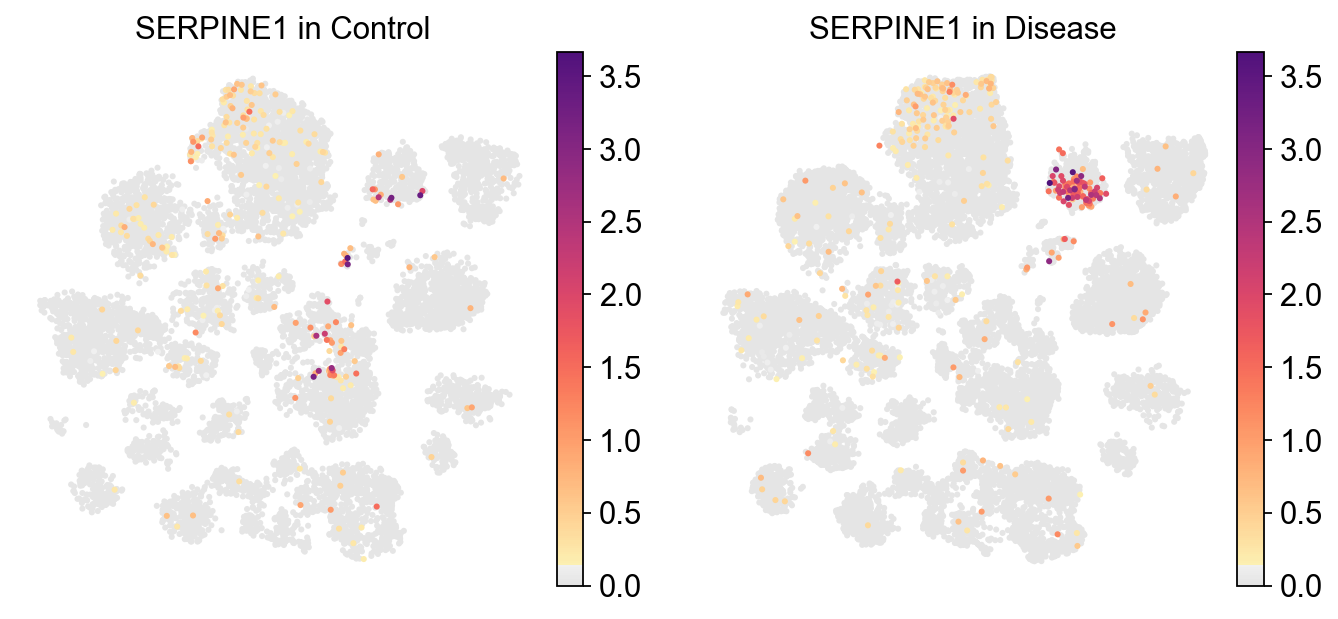

In [49]:
piaso.pl.plot_embeddings_split(
    adata,
    color='SERPINE1',
    layer='log1p',
    splitby='Condition',
    color_map=piaso.pl.color.c_color1,
    size=30,
    frameon=False,
    # vcenter=-np.log10(0.05),
    
)

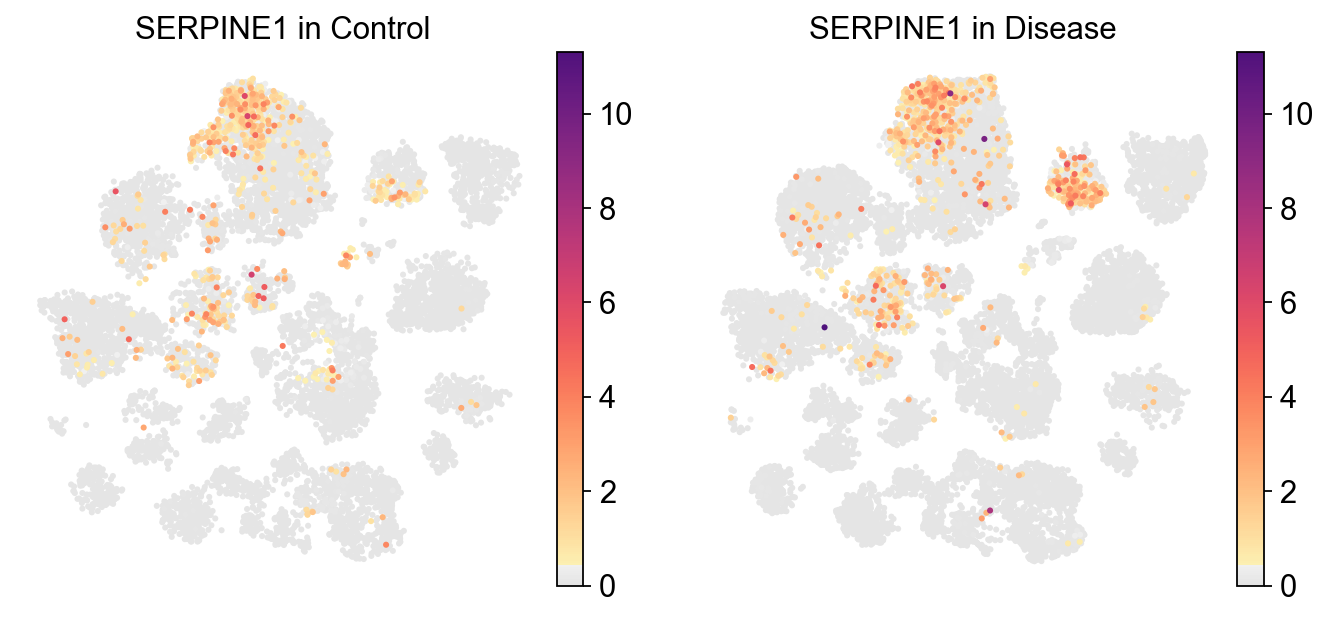

In [50]:
piaso.pl.plot_embeddings_split(
    adata,
    color='SERPINE1',
    layer='localFC',
    splitby='Condition',
    color_map=piaso.pl.color.c_color1,
    size=30,
    frameon=False,
    # vcenter=-np.log10(0.05),
    
)

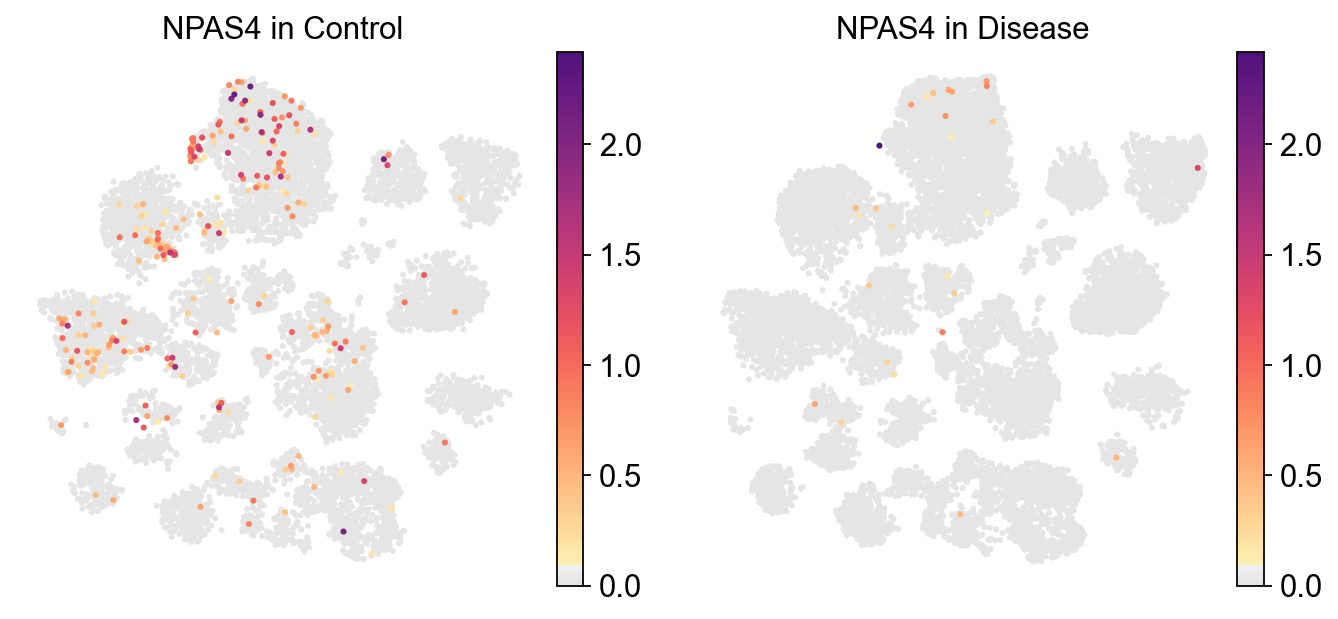

In [51]:
piaso.pl.plot_embeddings_split(
    adata,
    color='NPAS4',
    layer='log1p',
    splitby='Condition',
    color_map=piaso.pl.color.c_color1,
    size=30,
    frameon=False,
    # vcenter=-np.log10(0.05),
    
)

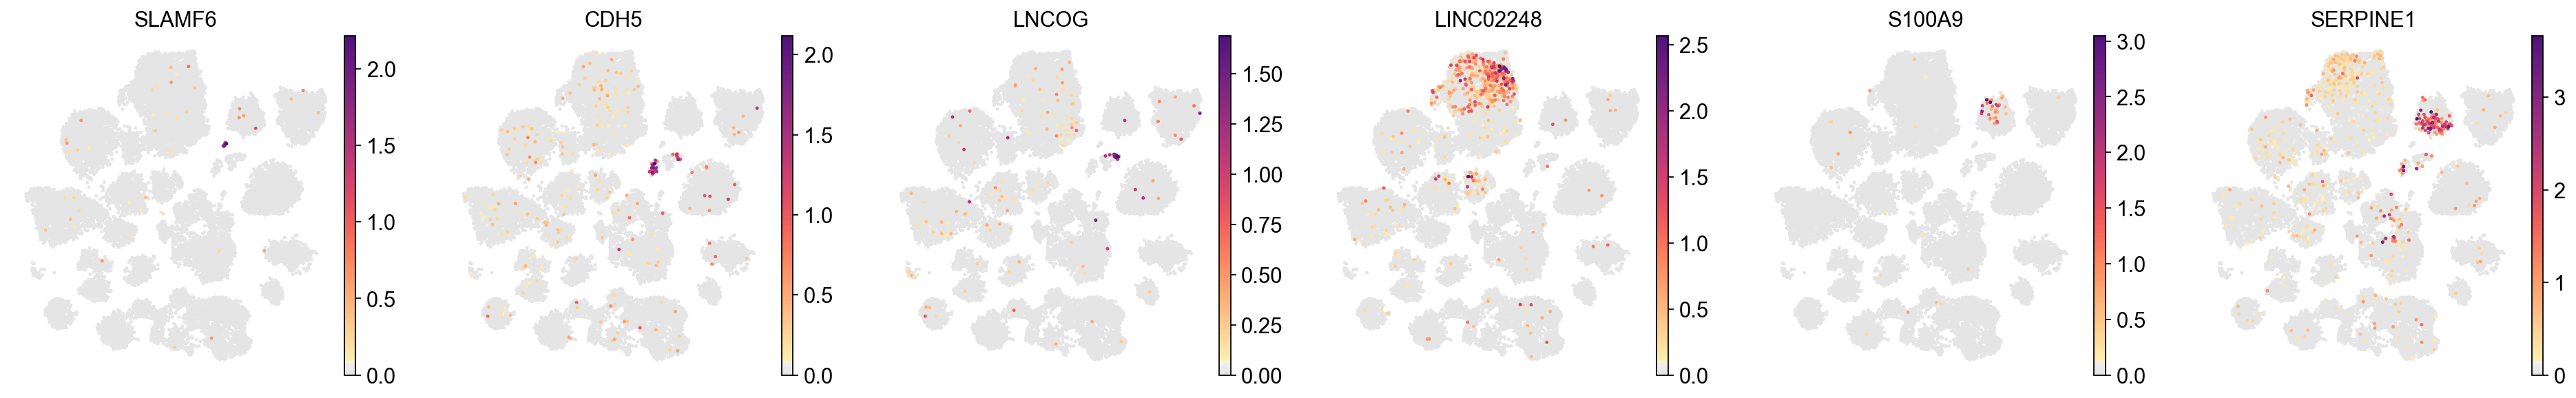

In [52]:
sc.pl.umap(
    adata,
    color=EG_top_geneset_df['EG_Disease_Gene'][20:26],
    color_map=piaso.pl.color.c_color1,
    # vmin=-5,
    # vmax=6,
    s=20,
    ncols=6,
    frameon=False,
)